# Estimating Correlation Using Discrete Copulas

In [388]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from scipy.stats import truncnorm, norm, multivariate_normal, nbinom
import scipy.stats as stats

import tools as tl

# load data
data1_4 = pd.read_csv("mt-datasets/Donor1_CD4_Genes.csv")
# normalization
data_norm = tl.RPM(data1_4)
fitted_para = pd.read_csv('fitted_data/fitted_para.csv')


data_pro = data_norm[fitted_para.columns.to_list()]
data_pro = data_pro.reset_index(drop=True)
N = data_pro.shape[0]

To calculate the correlation between two datasets, the usual approach is to assume a bivariate normal distribution. However, this assumption may not always be appropriate. For our data, as observed in the previous section, the datasets themselves are not normally distributed. This implies that the bivariate normal model is not suitable, as it also assumes that each marginal distribution is normally distributed.
We introduce a new method called Copula. This approach allows us to leverage the simulated marginal distributions for each dataset that we have already obtained. 

## 1. Copula
To introduce Copula, we first need to present a key theorem known as Sklar's Theorem.

### 1.1 Introduction
- **Sklar's Theorem** states that any multivariate distribution can be represented in terms of its marginal distributions and a copula that captures the dependencies between them. Specifically:

  If $ F $ is a joint cumulative distribution function (CDF) with marginals $ F_1, F_2, \ldots, F_d $, then there exists a copula $ C$ such that

   $$
   F(x_1, x_2, \ldots, x_d) = C(F_1(x_1), F_2(x_2), \ldots, F_d(x_d))
   $$

   where $ F_i $ is the marginal CDF of the $ i $-th variable, and $ C $ is the **copula function** that describes the dependence structure between the variables.

Conversely, any copula $ C $ with marginal distributions $ F_1, F_2, \ldots, F_d $ can be used to construct a joint CDF $ F $ as given above.

This theorem allows us to separate the modeling of marginal distributions from the modeling of dependencies, providing flexibility in statistical modeling and analysis.



### 1.2 Gaussian Copula

In practice, a copula function can be chosen from a wide variety of families, with the Gaussian copula being one of the most popular options. Among all copulas, the Gaussian copula is particularly favored due to its simplicity and effectiveness in capturing linear dependencies. In this context, we will use the Gaussian copula to estimate correlations.

**Definition**: For the case where $ n = 2 $, the Gaussian copula models the dependence between two random variables $ X_1 $ and $ X_2 $. And the    Gaussian copula is defined as:
$$
C_\text{Gauss}(u_1, u_2; \rho) = \Phi_\rho(\Phi^{-1}(u_1), \Phi^{-1}(u_2)),
$$
where:

- $ u_1 = F_{X_1}(x_1) $ and $ u_2 = F_{X_2}(x_2) $ are the marginal distributions (CDFs) of $ X_1 $ and $ X_2 $, respectively.
- $ \Phi^{-1} $ is the inverse of the standard normal CDF.
- $ \Phi_\rho $ is the CDF of the bivariate normal distribution with correlation $ \rho $.

Here, we have copula function $C_\text{Gauss}(u_1, u_2; \rho)$, we can also write the copula density as:
$$
c_{\text{Gauss}}(u_1, u_2; \rho) = \frac{\exp\left( -\frac{1}{2(1 - \rho^2)} \left[ \left( \Phi^{-1}(u_1) \right)^2 - 2 \rho \Phi^{-1}(u_1) \Phi^{-1}(u_2) + \left( \Phi^{-1}(u_2) \right)^2 \right] \right)}{2 \pi \sqrt{1 - \rho^2}}
$$
Here, $\rho$ is the only parameter in Gaussian copula. To obtain the value of $\rho$, we will use Markov Chain Monte Carlo (MCMC) again.



In [ ]:
def copulas_val(u1, u2, rho):
    '''Cauculate the Gaussian copula density value with given parameter'''
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]
    inv_u1 = norm.ppf(u1)
    inv_u2 = norm.ppf(u2)

    rv = multivariate_normal(mean, cov)
    inv_uv = np.column_stack((inv_u1, inv_u2))

    pdf_vals = rv.cdf(inv_uv)

    return pdf_vals

def log_copulas_val(u1, u2, rho):
    return np.log(copulas_val(u1, u2, rho))


## 2. Discrete Copula
According to the previous section, Sklar's theorem applies under the condition that all marginal distributions are continuous. However, this is not the case for our data, as we used binomial and ZINB models for simulation, both of which have discrete supports (integers). Therefore, we need to use a different approach to handle such discrete data. The method is from Smith, Michael & Khaled, Mohamad. (2011). Estimation of Copula Models With Discrete Margins via Bayesian Data Augmentation. Journal of the American Statistical Association. 107. 10.2139/ssrn.1937983. 

(Note that in this chapter, we focus solely on analyzing two datasets at a time.)

### 2.1 Augmented Distribution
We assume that the two marginal distributions are $X_1$, $X_2$, with $X=(X_1,X_2)$.
Since the marginals for each dataset is discrete, let $a_i = F(x_i^-)$ be the left-hand limit of $F_i$ at $x_i$ and $b_i = F(x_i)$. In our model, we have just $a_i = F(x_i-1)$. Then the probability mass function of $X$ can be written in a closed term:
$$
f(\boldsymbol{x}) = \Delta_{a_1}^{b_1}\Delta_{a_2}^{b_2}C(\boldsymbol{v}),
$$
where $\boldsymbol{v}=(v_1,v_2)$, and the operator here is the difference notation of Nelsen(2006). Expand the right-hand side we get:
\begin{equation}
f(\boldsymbol{x}) = C(b_1,b_2)+C(a_1,a_2)-C(b_1,a_2)-C(a_1,b_2).
\end{equation}
The following code uses the fitted parameters to compute all the values of $a_i$ and $b_i$ for each entry in our data.


In [ ]:
def get_range(data, para):
    N = data.shape[0]
    data_range = pd.DataFrame(index=range(N), columns=data.columns.to_list())
    for col in data.columns:
        para_0 = para[col]
        if not pd.isna(para_0[2]):
            for i in range(N):
                x = data_pro[col][i]
                data_range.loc[i, col] = [x, tl.zinb_cdf(
                    x-1, para_0), tl.zinb_cdf(x, para_0)]
        else:
            for i in range(N):
                x = data_pro[col][i]
                data_range.loc[i, col] = [x, stats.nbinom.cdf(
                    x-1, para_0[0], para_0[1]), stats.nbinom.cdf(x, para_0[0], para_0[1])]
    return data_range


data_range = get_range(data_pro, fitted_para)

Each entry now is a list consists three elements, where the first one is the original entry $x_{ij}$ $(i = 1,2,\dots,13,\ j = 1,2,\dots,N)$ where $N$ is the number of observations. And it is followed by the corresponding values of $a_{ij}$ and $b_{ij}$.

In [567]:
data_range.head()

,MT-CO1,MT-CO2,MT-CO3,MT-CYB,MT-ND1,MT-ND2,MT-ND3,MT-ND4,MT-ND4L,MT-ND5,MT-ND6,MT-ATP6,MT-ATP8
0,"[77441.0, 0.5494931718920115, 0.5495031351180442]","[178451.0, 0.8042939183561695, 0.8042982215164...","[127946.0, 0.7259127600818349, 0.7259196705169...","[67340.0, 0.36866368089010537, 0.368675518989968]","[40404.0, 0.7481610869869522, 0.7481770972523555]","[10101.0, 0.26612181009648495, 0.2661597222210...","[20202.0, 0.5000355074577995, 0.5000689934977431]","[16835.0, 0.7003565579567081, 0.7003893605171027]","[67340.0, 0.7765888533402772, 0.7765994278129278]","[23569.0, 0.6702710787105849, 0.6702981772054268]","[23569.0, 0.9981439427200626, 0.9981445653145318]","[10101.0, 0.6383928024554206, 0.6384434883281812]","[114478.0, 0.8644514956718803, 0.8644561756086..."
1,"[126984.0, 0.8798652985979444, 0.8798689438769...","[185185.0, 0.8316407741785891, 0.8316445973573...","[179894.0, 0.9407390924023786, 0.9407410551786...","[89947.0, 0.6203086212035477, 0.6203184600483052]","[42328.0, 0.7775227642911344, 0.7775372846741344]","[21164.0, 0.659809757297839, 0.6598380687512897]","[15873.0, 0.3481725030437295, 0.34820841665077...","[37037.0, 0.9777384184607226, 0.9777415685613068]","[79365.0, 0.8777934052794714, 0.8777998572798217]","[31746.0, 0.8406828279807048, 0.840697937809982]","[5291.0, 0.6585066768017456, 0.6585683964433557]","[10582.0, 0.6622401609659017, 0.6622886158700221]","[52910.0, 0.2863819766825337, 0.2863940900569975]"
2,"[67511.0, 0.44546286527267104, 0.4454737734148...","[126582.0, 0.4826806958350392, 0.4826884852276...","[80169.0, 0.29181945949389915, 0.2918292002052...","[63291.0, 0.320898614797742, 0.32091033858979395]","[29536.0, 0.5272305325695613, 0.527254904391431]","[8439.0, 0.20512762507635643, 0.2051628066158647]","[25316.0, 0.6552277610532915, 0.6552546126380523]","[12658.0, 0.5398897377755189, 0.5399334500290023]","[84388.0, 0.906723572709358, 0.9067286782302504]","[29536.0, 0.8041541364532993, 0.8041721376862299]","[0.0, 0.44438836125365655, 0.44438836132061227]","[4219.0, 0.2978611683526332, 0.29791507657585653]","[33755.0, 0.08918538317218355, 0.0891929945200..."
3,"[89606.0, 0.6612249207540469, 0.6612332790668716]","[82437.0, 0.1504379451516872, 0.15044406488781...","[82437.0, 0.3140728028518513, 0.3140826795487452]","[50179.0, 0.1763745582446479, 0.17638451436879...","[10753.0, 0.07795508710999204, 0.0779699568713...","[7168.0, 0.16244826047143449, 0.16248004098746...","[7168.0, 0.08083313405212827, 0.08085319914631...","[14337.0, 0.6099018477204521, 0.6099414248519098]","[46595.0, 0.47468189932979404, 0.4746998457397...","[21505.0, 0.6109567963719192, 0.610987149880462]","[10753.0, 0.9030349558365303, 0.9030608834085948]","[17921.0, 0.8974330616897686, 0.8974512307075327]","[50179.0, 0.2536986804153786, 0.25371048319593..."
4,"[23346.0, 0.03374442241313505, 0.0337488071411...","[101167.0, 0.2815784566327098, 0.2815861346565...","[42802.0, 0.03235600810978691, 0.0323591993532...","[27237.0, 0.022297309959533954, 0.022300465849...","[23346.0, 0.36732705375655483, 0.3673537658437...","[11673.0, 0.3267080723180914, 0.3267470154043366]","[15564.0, 0.3370782908073157, 0.33711417909225...","[0.0, 0.0917570698919008, 0.09175707003534263]","[54475.0, 0.6077718169593974, 0.6077874418026472]","[7782.0, 0.13450959514635935, 0.1345374328627178]","[0.0, 0.44438836125365655, 0.44438836132061227]","[3891.0, 0.2805863426044337, 0.2806377046551769]","[54475.0, 0.30544368217358464, 0.3054559228435..."


In this discrete copula model, we consider a joint distribution of $(X,U)$, with $U=(U_1,U_2)$ where each $U_i$ a uniform distribution on $[0,1]$
- Proposition: If $(X, U)$ has mixed probability density given by:
  $$
  f(\boldsymbol{x},\boldsymbol{u}) = f(\boldsymbol{x}|\boldsymbol{u})f(\boldsymbol{u})=\prod_{j=1}^{m} \mathbb{I}(F_j(x_j^-) \leq u_j < F_j(x_j)) c(\boldsymbol{u}),
\end{equation}
  where $ f(\mathbf{x}|\mathbf{u}) = \prod_{j=1}^{m} f(x_j | u_j)$, then the marginal probability mass function of $X$ is given by equation $(1)$.

In our case, we have $m=2$.
  

Let $\rho$ be the copula parameter, then we can write the mixed PDF as:
$$
f(\boldsymbol{x},\boldsymbol{u}|\rho) = \prod_{i=1}^{n}  c(\boldsymbol{u_i};\rho) \prod_{j=1}^{m=2} \mathbb{I}(a_{ij} \leq u_{ij} < b_{ij}),
$$
where $n$ is the number of observations, $\boldsymbol{u}=(u_1,u_2,\dots,u_n)$ and $\boldsymbol{u_i} = (u_{i1},u_{i2})$

### 2.2 Sampling Schemes
We then use MCMC to estimate the values of $\rho$ and $\boldsymbol{u}$. First we need to know the necessary conditional probabilities.


- **Sample $\boldsymbol{u}$**
    
    Here, we sample $\boldsymbol{u}$ each margin at a time. And we have for $j = 1, 2$:
    $$
    f(\boldsymbol{u}_j|\rho,\boldsymbol{x},\boldsymbol{u}_{k\neq j})\propto \prod_{i=1}^{n} \mathbb{I}(a_{ij} \leq u_{ij} < b_{ij})c_{j|k\neq j}(u_{ij}|u_{ik,k\neq j},\rho)\tag{2}
    $$
    Therefore, according to equation $(2)$, the latents $u_{ij}$ are generated from the conditional densities $c_{j|k\neq j}$ constrained to $[a_{ij} , b_{ij})$, and an iterate for $\boldsymbol{u_j}$ obtained.

    So first, we set the initial values for $\boldsymbol{u}$ with the constrained range for each entry $u_{ij}$:



In [ ]:
def set_initial(data):
    '''Set the initial values for matrix u
    Input:
    Dataframe with each entry be a list of length 3, ordered [x_ij, a_ij, b_ij]

    Return:
    Dataframe with each entry be a list of length 3, ordered [u_ij, a_ij, b_ij]
    '''
    N = data.shape[0]
    data_initial = pd.DataFrame(index=range(N), columns=data.columns.to_list())
    for col in data.columns:
        for i in range(N):
            data_initial.loc[i, col] = [random.uniform(
                data[col][i][1], data[col][i][2])]
            data_initial.loc[i, col] += data[col][i][1:]
    return data_initial


initial_u = set_initial(data_range)
initial_u.head()

In [ ]:
def prop_u(u, ranges, rho):
    '''Get the proposal value for u with given constraint range'''
    u = np.asarray(u)

    # Compute inverse CDF (norm.ppf) for u
    inv2 = norm.ppf(u)

    # Extract lower and upper bounds from the ranges matrix
    a = [lis[0] for lis in ranges]
    b = [lis[1] for lis in ranges]

    # Compute inverse CDF for the ranges
    inv_a = norm.ppf(a)
    inv_b = norm.ppf(b)

    # Compute mu and sigma for the truncated normal distribution
    mu = inv2 * rho
    sigma = np.sqrt(1 - rho ** 2)

    lower_bounds = (inv_a - mu) / sigma
    # lower_bounds = np.maximum(0, lower_bounds)
    upper_bounds = (inv_b - mu) / sigma

    dif_indices = [i for i in range(
        len(lower_bounds)) if lower_bounds[i] != upper_bounds[i]]
    inv1 = truncnorm.rvs(lower_bounds[dif_indices], upper_bounds[dif_indices],
                         loc=mu[dif_indices], scale=sigma, size=len(dif_indices))

    if len(dif_indices) != len(lower_bounds):
        res = lower_bounds
        for i in range(len(inv1)):
            res[dif_indices[i]] = inv1[i]
        inv1 = res

    # Compute the cumulative distribution function (CDF) of the generated samples
    val = norm.cdf(inv1)

    return val

prop_u([0.5, 0.4], [[0.4, 0.7], [0.2, 0.8]], 0.5)

In [ ]:
def update_u(u1_pack, u2_pack, rho):
    '''propose new u_2 given the values form other'''
    N = u1_pack.shape[0]
    col2 = u2_pack.columns
    u1_condition = [u1_pack[u1_pack.columns[0]][i][0] for i in range(N)]
    u2_ranges = [u2_pack[col2[0]][i][1:] for i in range(N)]

    u2 = pd.DataFrame(index=range(N), columns=col2.to_list())

    new_val = prop_u(u1_condition, u2_ranges, rho)
    u2[col2[0]] = [[new_val[i], u2_pack[col2[0]][i][1], u2_pack[col2[0]][i][2]]
                   for i in range(N)]

    return u2

- **Sample $\boldsymbol{\rho}$**
$$
f(\rho|\boldsymbol{u},\boldsymbol{x}) = f(\rho|\boldsymbol{u}) \propto \prod_{i=1}^{n} c(\boldsymbol{u_i};\rho)\pi(\rho)\tag{3}
$$
Here, $\pi(\rho)$ is the prior, and we choose the prior to be the truncated normal distribution between $-1$ and $1$ with standard deviation $\sigma_\rho$. So we have the proprosal algorithm for $\rho$ as following:

In [ ]:
def truncnorm_prop_rho(x, sigma):  # proposal for rho 
    return truncnorm.rvs((-1-x) / sigma, (1-x) / sigma, loc=x, scale=sigma)

def truncnorm_rho_pdf(x, x_p, sigma):
    rv = truncnorm((-1-x) / sigma, (1-x) / sigma, loc=x, scale=sigma)
    return rv.pdf(x_p)

## 2.3 MCMC

In [527]:

def gc_acceptance_ratio(u, u_p, rho_vals):
    rho, rho_p = rho_vals
    u1, u2 = u
    u1_p, u2_p = u_p

    u1 = u1.to_numpy()
    u2 = u2.to_numpy()
    u1_p = u1_p.to_numpy()
    u2_p = u2_p.to_numpy()
    u1 = [li[0][0] for li in u1]
    u2 = [li[0][0] for li in u2]
    u1_p = [li[0][0] for li in u1_p]
    u2_p = [li[0][0] for li in u2_p]

    acc = sum(log_copulas_val(u1_p, u2_p, rho_p)) - \
        sum(log_copulas_val(u1, u2, rho))
    return acc
# gc_acceptance_ratio(initial_u[['MT-CO1']],initial_u[['MT-CO2']],(0.4,0.5),0.01)

In [396]:
def nb_marginal(num, r, p, u_raw):

    N, J = num.shape

    rtn = [np.zeros((N, J)), np.zeros((N, J))]

    for j in range(J):
        for n in range(N):

            Ubound = nbinom.cdf(num[n, j], r[j], p[j])
            Lbound = 0
            if num[n, j] > 0:
                Lbound = nbinom.cdf(num[n, j] - 1, r[j], p[j])
            UmL = Ubound - Lbound
            rtn[0][n, j] = norm.ppf(Lbound + UmL * u_raw[n, j])
            rtn[1][n, j] = np.log(UmL)

    return rtn


def apply_ng_marginal(name1, name2, u):
    num = data_pro[[name1, name2]].values
    r = fitted_para.loc[0, [name1, name2]].values
    p = fitted_para.loc[1, [name1, name2]].values
    u_raw = u
    return nb_marginal(num, r, p, u_raw)

In [547]:
def metropolis_hastings_gc(u1, u2, sigma, n_iter=10000, burn_in=2000, thin=5):

    trace = np.zeros(n_iter)
    trace[0] = 0

    acceptance_rate = np.zeros(n_iter)
    rho = trace[0]

    for i in range(1, n_iter):
        rho = trace[i-1]
        rho_p = truncnorm_prop_rho(rho, sigma)

        u1_p = update_u(u2, u1, rho_p)
        u2_p = update_u(u1, u2, rho_p)

        alpha = gc_acceptance_ratio(
            (u1, u2), (u1_p, u2_p), (rho, rho_p))
        u = np.log(np.random.uniform(0., 1.))

        if u < alpha:
            trace[i] = rho_p
            acceptance_rate[i-1] = 1
            u1 = u1_p
            u2 = u2_p
        else:
            trace[i] = rho
    print(u1.columns[0]+' and '+u2.columns[0] +
          " acceptance rate is: %.2f" % acceptance_rate[burn_in:].mean())
    return pd.DataFrame(trace[burn_in::thin])


trace_0 = metropolis_hastings_gc(
    initial_u[['MT-CO1']], initial_u[['MT-CO3']], sigma=0.01, n_iter=500, burn_in=100, thin=5)

MT-CO1 and MT-CO3 acceptance rate is: 0.42


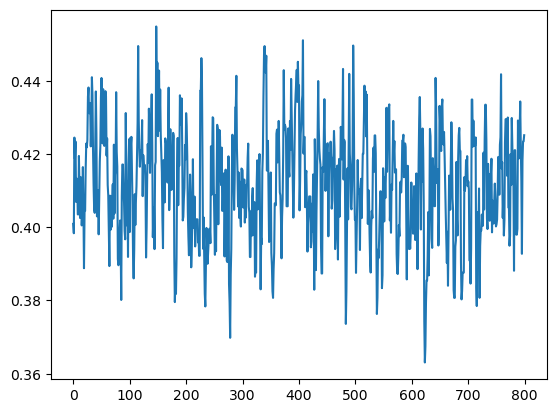

In [468]:
plt.plot(trace_0[0])

In [548]:
cor_o = np.zeros((13,13))

In [522]:
names = data_range.columns.to_list()
traces = pd.DataFrame(index=names, columns=names)

for i in range(13):
    for j in range(i+1, 13):
        if cor_o[i, j] == 0 or cor_o[i, j] == 0.5:
            tra = metropolis_hastings_gc(initial_u[[names[i]]], initial_u[[
                                         names[j]]], sigma=0.01, n_iter=5000, burn_in=1000, thin=5)
            traces.loc[names[i], names[j]] = [
                tra[:100].mean()-tra[-100:].mean(), tra, tra.mean()]
            cor_o[i, j] = float(tra.mean().iloc[0])
            print(cor_o[i, j])
    print(cor_o)

MT-CO1 and MT-ND4L acceptance rate is: 0.47
0.19308761989596945
MT-CO1 and MT-ATP8 acceptance rate is: 0.49
0.17667761129578988
[[0.         0.39808091 0.41255409 0.27034225 0.11029015 0.1318834
  0.22785093 0.1805153  0.19308762 0.16011204 0.06018092 0.12887701
  0.17667761]
 [0.         0.         0.55464423 0.61195755 0.26094905 0.31477696
  0.36627267 0.2887048  0.46425822 0.24824088 0.09865252 0.24917395
  0.2805608 ]
 [0.         0.         0.         0.53021193 0.39982817 0.27644872
  0.38017871 0.24175558 0.42302222 0.27820589 0.09587322 0.23117703
  0.49755181]
 [0.         0.         0.         0.         0.34211208 0.32457564
  0.32318831 0.29274766 0.46628096 0.31334364 0.12434996 0.22218988
  0.3001385 ]
 [0.         0.         0.         0.         0.         0.27784376
  0.25643388 0.19657079 0.32007337 0.25399693 0.11396165 0.17635163
  0.40584762]
 [0.         0.         0.         0.         0.         0.
  0.19710705 0.24957436 0.24085569 0.180313   0.11753756 0.2035

In [564]:
cor_o=np.array([[0.        , 0.39808091, 0.41255409, 0.27034225, 0.11029015,
        0.1318834 , 0.22785093, 0.1805153 , 0.19308762, 0.16011204,
        0.06018092, 0.12887701, 0.17667761],
       [0.        , 0.        , 0.55464423, 0.61195755, 0.26094905,
        0.31477696, 0.36627267, 0.2887048 , 0.46425822, 0.24824088,
        0.09865252, 0.24917395, 0.2805608 ],
       [0.        , 0.        , 0.        , 0.53021193, 0.39982817,
        0.27644872, 0.38017871, 0.24175558, 0.42302222, 0.27820589,
        0.09587322, 0.23117703, 0.49755181],
       [0.        , 0.        , 0.        , 0.        , 0.34211208,
        0.32457564, 0.32318831, 0.29274766, 0.46628096, 0.31334364,
        0.12434996, 0.22218988, 0.3001385 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.27784376, 0.25643388, 0.19657079, 0.32007337, 0.25399693,
        0.11396165, 0.17635163, 0.40584762],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.19710705, 0.24957436, 0.24085569, 0.180313  ,
        0.11753756, 0.20350639, 0.21225752],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.18935214, 0.32095563, 0.20150825,
        0.07826799, 0.16123498, 0.31159686],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.29108253, 0.13930502,
        0.04541334, 0.17996165, 0.20744545],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.26883314,
        0.07547245, 0.22106115, 0.31116224],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.36893706, 0.08178057, 0.26021007],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.08856672, 0.12355176],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.15946843],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

In [562]:
df = pd.DataFrame(cor_o, columns=names,index=names)


,MT-CO1,MT-CO2,MT-CO3,MT-CYB,MT-ND1,MT-ND2,MT-ND3,MT-ND4,MT-ND4L,MT-ND5,MT-ND6,MT-ATP6,MT-ATP8
MT-CO1,0.0,0.398081,0.412554,0.270342,0.110290,0.131883,0.227851,0.180515,0.193088,0.160112,0.060181,0.128877,0.176678
MT-CO2,0.0,0.000000,0.554644,0.611958,0.260949,0.314777,0.366273,0.288705,0.464258,0.248241,0.098653,0.249174,0.280561
MT-CO3,0.0,0.000000,0.000000,0.530212,0.399828,0.276449,0.380179,0.241756,0.423022,0.278206,0.095873,0.231177,0.497552
MT-CYB,0.0,0.000000,0.000000,0.000000,0.342112,0.324576,0.323188,0.292748,0.466281,0.313344,0.124350,0.222190,0.300138
MT-ND1,0.0,0.000000,0.000000,0.000000,0.000000,0.277844,0.256434,0.196571,0.320073,0.253997,0.113962,0.176352,0.405848
MT-ND2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.197107,0.249574,0.240856,0.180313,0.117538,0.203506,0.212258
MT-ND3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.189352,0.320956,0.201508,0.078268,0.161235,0.311597
MT-ND4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.291083,0.139305,0.045413,0.179962,0.207445
MT-ND4L,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.268833,0.075472,0.221061,0.311162
MT-ND5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.368937,0.081781,0.260210


In [526]:
cor_o

array([[0.        , 0.39808091, 0.41255409, 0.27034225, 0.11029015,
        0.1318834 , 0.22785093, 0.1805153 , 0.19308762, 0.16011204,
        0.06018092, 0.12887701, 0.17667761],
       [0.        , 0.        , 0.55464423, 0.61195755, 0.26094905,
        0.31477696, 0.36627267, 0.2887048 , 0.46425822, 0.24824088,
        0.09865252, 0.24917395, 0.2805608 ],
       [0.        , 0.        , 0.        , 0.53021193, 0.39982817,
        0.27644872, 0.38017871, 0.24175558, 0.42302222, 0.27820589,
        0.09587322, 0.23117703, 0.49755181],
       [0.        , 0.        , 0.        , 0.        , 0.34211208,
        0.32457564, 0.32318831, 0.29274766, 0.46628096, 0.31334364,
        0.12434996, 0.22218988, 0.3001385 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.27784376, 0.25643388, 0.19657079, 0.32007337, 0.25399693,
        0.11396165, 0.17635163, 0.40584762],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.19710

In [565]:
names = data_pro.columns.to_list()

def kendalls_tau(name1, name2):
    tau = 0

    rho = 0.1  # cor_o[pos1, pos2]
    x1 = data_range[name1]
    x2 = data_range[name2]

    for val1 in x1:

        for val2 in x2:
            f = sum(copulas_val([val1[2], val1[1]], [val2[2], val2[1]], rho))-sum(copulas_val([val1[1], val1[2]],
                                                                                              [val2[2], val2[1]], rho))
            term2 = sum(copulas_val([val1[2], val1[1], val1[2], val1[1]], [
                val2[2], val2[1], val2[1], val2[2]], rho))
            tau += f*term2
    tau -= 1
    return tau


kendalls_tau('MT-CO1', 'MT-CO2')

[0.5495031351180442, 0.5494931718920115] [0.8042982215164969, 0.8042939183561695] [0.12440612 0.12438095] [0.85707478 0.85705921]
[0.5494931718920115, 0.5495031351180442] [0.8042982215164969, 0.8042939183561695] [0.12438095 0.12440612] [0.85707478 0.85705921]
[0.5495031351180442, 0.5494931718920115, 0.5495031351180442, 0.5494931718920115] [0.8042982215164969, 0.8042939183561695, 0.8042939183561695, 0.8042982215164969] [0.12440612 0.12438095 0.12440612 0.12438095] [0.85707478 0.85705921 0.85705921 0.85707478]
[0.5495031351180442, 0.5494931718920115] [0.8316445973573345, 0.8316407741785891] [0.12440612 0.12438095] [0.96068454 0.96066934]
[0.5494931718920115, 0.5495031351180442] [0.8316445973573345, 0.8316407741785891] [0.12438095 0.12440612] [0.96068454 0.96066934]
[0.5495031351180442, 0.5494931718920115, 0.5495031351180442, 0.5494931718920115] [0.8316445973573345, 0.8316407741785891, 0.8316407741785891, 0.8316445973573345] [0.12440612 0.12438095 0.12440612 0.12438095] [0.96068454 0.9606

KeyboardInterrupt: 